## Youtube Trend Analysis
- Which months, time of the day, day of the week are most popular for uploads?
- Who are the top channels?
- What are the most common words used in titles? What is the relationship between these words and their views?
- What are the most popular tags? Which are the most liked / disliked tags?
- What kinds of videos get the most comments?
- How does the sentiment of the description correlate with views, comments, likes/dislikes?

### Preprocessing:
- Create date columns: hour, day, month
- Parse keywords from titles, lowercase
- Parse keywords from tags
- Link category ids to categories

### Analysis:
- Find trends between comments, likes, dislikes and channel / date / tags

### Load dataset, preprocessing

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from collections import Counter
import json

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/christinejiang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/christinejiang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/christinejiang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
path = '/Users/christinejiang/Documents/Python/personal_projects/youtube_trends/'
videos = pd.read_csv(path+'USvideos.csv')
videos = videos.drop(['thumbnail_link','video_error_or_removed'], axis=1)
videos.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,False,False,I know it's been a while since we did this sho...


In [4]:
display(videos.describe())
print(videos.shape)

,category_id,views,likes,dislikes,comment_count
count,40949.000000,4.094900e+04,4.094900e+04,4.094900e+04,4.094900e+04
mean,19.972429,2.360785e+06,7.426670e+04,3.711401e+03,8.446804e+03
std,7.568327,7.394114e+06,2.288853e+05,2.902971e+04,3.743049e+04
min,1.000000,5.490000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,17.000000,2.423290e+05,5.424000e+03,2.020000e+02,6.140000e+02
50%,24.000000,6.818610e+05,1.809100e+04,6.310000e+02,1.856000e+03
75%,25.000000,1.823157e+06,5.541700e+04,1.938000e+03,5.755000e+03
max,43.000000,2.252119e+08,5.613827e+06,1.674420e+06,1.361580e+06


(40949, 14)


In [5]:
videos.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'comments_disabled', 'ratings_disabled', 'description'],
      dtype='object')

In [93]:
#create date columns
videos['pd_datetime'] = pd.to_datetime(videos['publish_time'])
videos['date'] = videos['pd_datetime'].dt.date
videos['day'] = videos['pd_datetime'].dt.day
videos['hour'] = videos['pd_datetime'].dt.hour
videos['month'] = videos['pd_datetime'].dt.month
videos['year'] = videos['pd_datetime'].dt.year
videos['weekday'] = videos['pd_datetime'].dt.day_name()
print('date columns created')

#create keyword column from titles
#lowercase all of the titles, then strip punctuation
#the r in front of the bracket represents raw string notation, so don't treat backslashes as escape characters
#if not using raw string, will use bracket as escape notation
#\w is anything alphanumeric (letters or numbers)
#\s are whitespace characters
#^ complements the set, so matches anything that is not included
#re.sub(r'[^\w\s]','',x) means substitute any non whitespace/alphanumeric character with nothing 
videos['cleaned_title'] = [re.sub(r'[^\w\s]', '', x) for x in videos['title'].str.lower()]
print('clean title created')

#create column of lemmatized sentence
#for the tokenized version of each sentence, lemmatize each word and return if not a stopword and length > 2, join with a space
#apply lambda function to cleaned title, which has no punctuation
lemmatizer = WordNetLemmatizer()
stopword_list = stopwords.words('english')
lem_title = lambda title: [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(title) 
                            if word not in stopword_list and len(word) > 2]
videos['keywords'] = videos['cleaned_title'].apply(lem_title)
print('titles lemmatized')

#create bag of words by splitting lemmatized titles, adding to bow list
#extend combines lists, append adds lists to lists
#count word frequency
bow = []
for word_list in videos['keywords']:
    bow.extend(word_list)
counts = Counter(bow)
title_counts = pd.DataFrame.from_dict(counts, orient='index').sort_values(by=0,ascending=False).reset_index().rename(columns={'index':'word',0:'count'})
top_200_list = list(title_counts['word'][0:200].values)
print('top 200 words collected')

#create count of top 200 words in lemmatized title
top_200_counter = lambda keywords: sum(word in top_200_list for word in keywords)
videos['top_200_count'] = videos['keywords'].apply(top_200_counter)

#map category IDs to categories
with open(path+'category_mappings.json') as f:
    data = json.load(f)
category_dict = {int(item['id']): item['snippet']['title'] for item in data['items']}
videos['category_name'] = videos['category_id'].map(category_dict)
print('categories mapped')

#create categorical column for weekdays
videos['weekday_cat'] = pd.Categorical(videos['weekday'], 
                                       categories=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday'],
                                      ordered=True)
print('weekday order created')

videos['likes_dislikes_ratio'] = 1.0*(videos['likes']/videos['dislikes'])
videos['likes_dislikes_ratio'] = videos['likes_dislikes_ratio'].replace(np.inf, np.nan)
videos['dislikes_likes_ratio'] = 1.0*(videos['dislikes']/videos['likes'])
videos['dislikes_likes_ratio'] = videos['dislikes_likes_ratio'].replace(np.inf, np.nan)
videos['comments_views_ratio'] = 1.0*(videos['comment_count']/videos['views'])

videos.head()

date columns created
clean title created
titles lemmatized
top 200 words collected
categories mapped
weekday order created


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,year,weekday,cleaned_title,keywords,top_200_count,category_name,weekday_cat,likes_dislikes_ratio,comments_views_ratio,dislikes_likes_ratio
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,...,2017,Monday,we want to talk about our marriage,"[want, talk, marriage]",1,People & Blogs,Monday,19.395482,0.021318,0.051558
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,...,2017,Monday,the trump presidency last week tonight with jo...,"[trump, presidency, last, week, tonight, john,...",4,Entertainment,Monday,15.812724,0.005252,0.063240
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,...,2017,Sunday,racist superman rudy mancuso king bach lele ...,"[racist, superman, rudy, mancuso, king, bach, ...",1,Comedy,Sunday,27.352126,0.002563,0.036560
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,...,2017,Monday,nickelback lyrics real or fake,"[nickelback, lyric, real, fake]",2,Entertainment,Monday,15.273273,0.006253,0.065474
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,...,2017,Sunday,i dare you going bald,"[dare, going, bald]",0,Entertainment,Sunday,66.483157,0.008359,0.015041


### Exploratory analysis

#### Insights:
- 2-6pm is most popular time for uploads
- views/comments are highest at 4am and 9am; there might be a few results skewing this
- metrics for months are incomplete
- uploads are more common during the week, but most liked / commented on sundays and fridays
- trending videos started picking up at the end of 2017
- mondays have the highest peaks for views
- entertainmnet, music, and style are most uploaded categories
- videos with highest comment-to-views ratio are gaming, politics, news, nonprofits/activism
- videos with highest like ratios are pets, music, animals
- videos with highest dislike ratio are news/politics by far

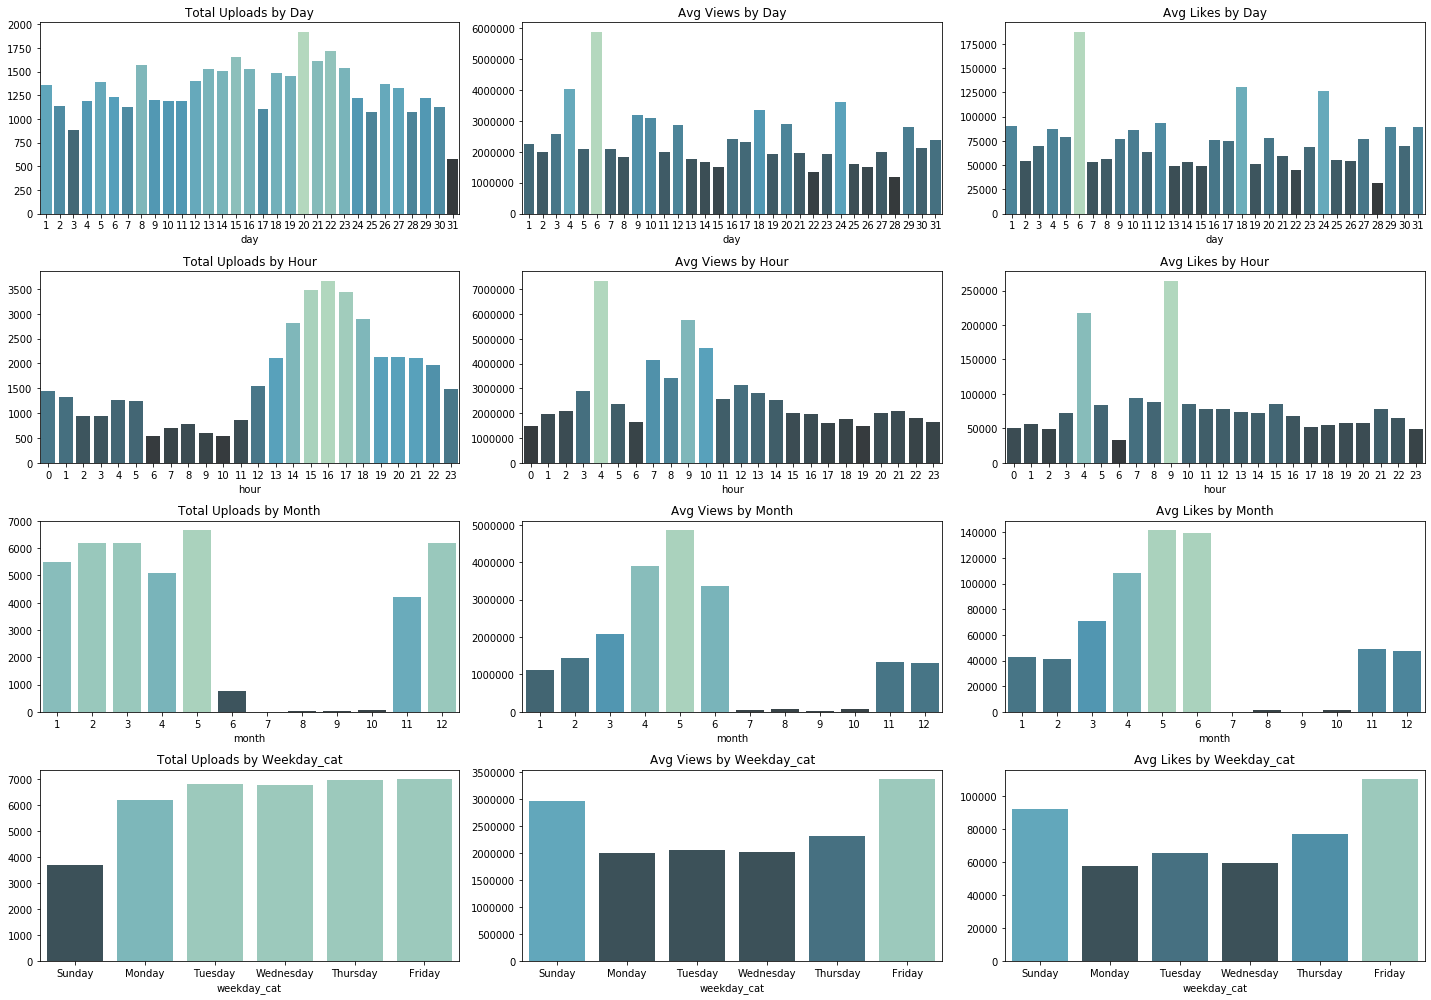

In [8]:
#normalize groupby values 0-1
#convert normalized values to indices (integers)
#retrieve palette with corresponding colors, given number of values
#return array of arrays, where each inner array is the color values assigned to a bar
def colors_from_values(values, palette_name):
    normalized = (values - min(values)) / (max(values) - min(values))
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    palette = sns.color_palette(palette_name, len(values))
    final_palette = np.array(palette).take(indices, axis=0)
    return final_palette

figure,axes = plt.subplots(4,3,figsize=(20,14))
plots = list(axes.flatten())
categories = ['day','hour','month', 'weekday_cat']
for i, category in enumerate(categories):
    views = videos.groupby(category)['views'].mean().rename('Avg Views')
    uploads = videos.groupby(category)['video_id'].count().rename('Total Uploads')
    likes = videos.groupby(category)['likes'].mean().rename('Avg Likes')
    for x, count in enumerate([uploads, views, likes]):
        sns.barplot(count.index, count.values, ax=axes[i,x], palette=colors_from_values(count.values, "GnBu_d"))
        axes[i,x].set_title(count.name +' by '+category.capitalize())
figure.tight_layout()

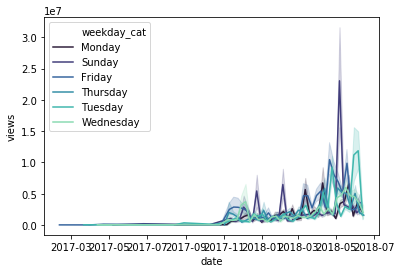

In [9]:
videos_2018 = videos.loc[videos['year']>=2017]
sns.lineplot(x='date', y='views', data=videos_2018, hue='weekday_cat', palette='mako')

In [10]:
videos.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,month,year,weekday,cleaned_title,keywords,top_200_count,category_name,weekday_cat,likes_dislikes_ratio,comments_views_ratio
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,...,11,2017,Monday,we want to talk about our marriage,"[want, talk, marriage]",1,People & Blogs,Monday,19.395482,0.021318
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,...,11,2017,Monday,the trump presidency last week tonight with jo...,"[trump, presidency, last, week, tonight, john,...",4,Entertainment,Monday,15.812724,0.005252
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,...,11,2017,Sunday,racist superman rudy mancuso king bach lele ...,"[racist, superman, rudy, mancuso, king, bach, ...",1,Comedy,Sunday,27.352126,0.002563
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,...,11,2017,Monday,nickelback lyrics real or fake,"[nickelback, lyric, real, fake]",2,Entertainment,Monday,15.273273,0.006253
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,...,11,2017,Sunday,i dare you going bald,"[dare, going, bald]",0,Entertainment,Sunday,66.483157,0.008359


In [103]:
videos.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'comments_disabled', 'ratings_disabled', 'description', 'pd_datetime',
       'date', 'day', 'hour', 'month', 'year', 'weekday', 'cleaned_title',
       'keywords', 'top_200_count', 'category_name', 'weekday_cat',
       'likes_dislikes_ratio', 'comments_views_ratio', 'dislikes_likes_ratio'],
      dtype='object')

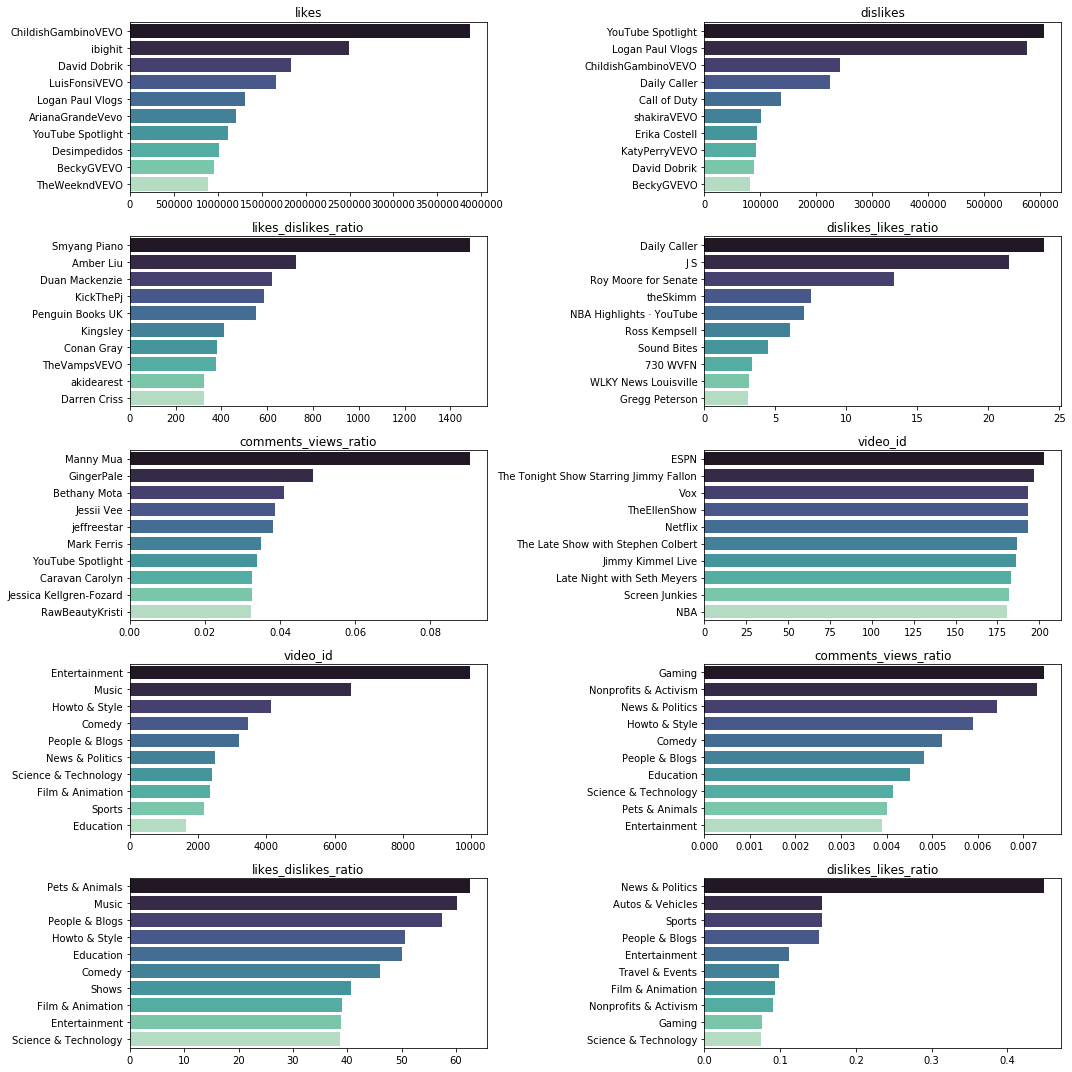

In [110]:
channel_uploads = videos.groupby('channel_title')['video_id'].count().sort_values(ascending=False)[0:10]
channel_avg_likes = videos.groupby('channel_title')['likes'].mean().sort_values(ascending=False)[0:10]
channel_avg_dislikes = videos.groupby('channel_title')['dislikes'].mean().sort_values(ascending=False)[0:10]
channel_likes_ratio = videos.groupby('channel_title')['likes_dislikes_ratio'].mean().sort_values(ascending=False)[0:10]
channel_dislikes_ratio = videos.groupby('channel_title')['dislikes_likes_ratio'].mean().sort_values(ascending=False)[0:10]
channel_comments_ratio = videos.groupby('channel_title')['comments_views_ratio'].mean().sort_values(ascending=False)[0:10]
category_uploads = videos.groupby('category_name')['video_id'].count().sort_values(ascending=False)[0:10]
category_comments_ratio = videos.groupby('category_name')['comments_views_ratio'].mean().sort_values(ascending=False)[0:10]
category_likes_ratio = videos.groupby('category_name')['likes_dislikes_ratio'].mean().sort_values(ascending=False)[0:10]
category_dislikes_ratio = videos.groupby('category_name')['dislikes_likes_ratio'].mean().sort_values(ascending=False)[0:10]


plot, axes = plt.subplots(5,2,figsize=(15,15))
axes=axes.flatten()
for i,metric in enumerate([channel_avg_likes, channel_avg_dislikes, channel_likes_ratio, channel_dislikes_ratio, 
                           channel_comments_ratio, channel_uploads, category_uploads, category_comments_ratio,
                          category_likes_ratio, category_dislikes_ratio]):
    graph = sns.barplot(x=metric.values, y=metric.index, ax=axes[i], palette='mako')
    axes[i].set_title(metric.name)
    axes[i].set_ylabel('')
    plot.tight_layout()
    

In [145]:
video_max_date = videos.groupby('video_id')['trending_date'].max()
days_trending = videos.groupby('video_id')['trending_date'].count().rename('days_trending')
videos_dedup = pd.merge(video_max_date, videos, how='inner', on=['video_id','trending_date'])
videos_final = pd.merge(videos_dedup, days_trending, on='video_id', how='inner')
videos_final.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,weekday,cleaned_title,keywords,top_200_count,category_name,weekday_cat,likes_dislikes_ratio,comments_views_ratio,dislikes_likes_ratio,days_trending
0,-0CMnp02rNY,18.11.06,Mindy Kaling's Daughter Had the Perfect Reacti...,TheEllenShow,24,2018-06-04T13:00:00.000Z,"ellen|""ellen degeneres""|""the ellen show""|""elle...",800359,9773,332,...,Monday,mindy kalings daughter had the perfect reactio...,"[mindy, kalings, daughter, perfect, reaction, ...",2,Entertainment,Monday,29.436747,0.000529,0.033971,6
1,-0NYY8cqdiQ,18.01.02,Megan Mullally Didn't Notice the Interesting P...,TheEllenShow,24,2018-01-29T14:00:39.000Z,"megan mullally|""megan""|""mullally""|""will and gr...",563746,4429,54,...,Monday,megan mullally didnt notice the interesting pa...,"[megan, mullally, didnt, notice, interesting, ...",0,Entertainment,Monday,82.018519,0.000167,0.012192,1
2,-1Hm41N0dUs,18.30.04,Cast of Avengers: Infinity War Draws Their Cha...,Jimmy Kimmel Live,23,2018-04-27T07:30:02.000Z,"jimmy|""jimmy kimmel""|""jimmy kimmel live""|""late...",1882352,38165,530,...,Friday,cast of avengers infinity war draws their char...,"[cast, avenger, infinity, war, draw, character]",4,Comedy,Friday,72.009434,0.000750,0.013887,3
3,-1yT-K3c6YI,17.30.11,YOUTUBER QUIZ + TRUTH OR DARE W/ THE MERRELL T...,Molly Burke,22,2017-11-28T18:30:43.000Z,"youtube quiz|""youtuber quiz""|""truth or dare""|""...",198315,6950,184,...,Tuesday,youtuber quiz truth or dare w the merrell twins,"[youtuber, quiz, truth, dare, merrell, twin]",0,People & Blogs,Tuesday,37.771739,0.003706,0.026475,4
4,-2RVw2_QyxQ,17.16.11,2017 Champions Showdown: Day 3,Saint Louis Chess Club,27,2017-11-12T02:39:01.000Z,"Chess|""Saint Louis""|""Club""",71089,460,27,...,Sunday,2017 champions showdown day 3,"[2017, champion, showdown, day]",2,Education,Sunday,17.037037,0.000281,0.058696,3


In [155]:
videos_dedup['video_id'].value_counts()

pd.DataFrame(video_max_date).reset_index()['video_id'].value_counts().sort_values(ascending=False)

37R2_bvJjGM    1
B2W7c3XRBwQ    1
F7jcFXTnBiQ    1
JpvC3j9Qxus    1
qNl4-y6q5rc    1
              ..
exGGotfSuH0    1
ir8UofAKNCM    1
UmXbLTbi8Hg    1
894rSubVE5E    1
YI3tsmFsrOg    1
Name: video_id, Length: 6351, dtype: int64

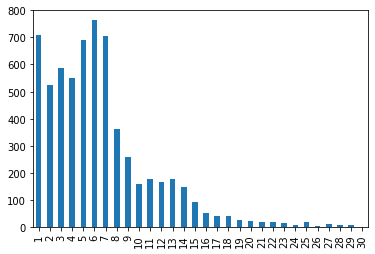

In [123]:
days_trending.value_counts().sort_index().plot(kind='bar')

In [114]:
videos.loc[videos['video_id']=='j4KvrAUjn6c']
#there are duplicate rows for videos that were trending for multiple days
#need to take the most recent record for each video, and use that as its record
#create column to capture the number of days a video was trending for
#basically on the last day a video was trending, what was its status

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,year,weekday,cleaned_title,keywords,top_200_count,category_name,weekday_cat,likes_dislikes_ratio,comments_views_ratio,dislikes_likes_ratio
34550,j4KvrAUjn6c,18.14.05,WE MADE OUR MOM CRY...HER DREAM CAME TRUE!,Lucas and Marcus,24,2018-05-13T18:03:56.000Z,"Lucas and Marcus|""Marcus and Lucas""|""Dobre""|""D...",2131702,54280,4696,...,2018,Sunday,we made our mom cryher dream came true,"[made, mom, cryher, dream, came, true]",3,Entertainment,Sunday,11.558773,0.005022,0.086514
34752,j4KvrAUjn6c,18.15.05,WE MADE OUR MOM CRY...HER DREAM CAME TRUE!,Lucas and Marcus,24,2018-05-13T18:03:56.000Z,"Lucas and Marcus|""Marcus and Lucas""|""Dobre""|""D...",3906727,77378,12160,...,2018,Sunday,we made our mom cryher dream came true,"[made, mom, cryher, dream, came, true]",3,Entertainment,Sunday,6.363322,0.004063,0.157151
34901,j4KvrAUjn6c,18.15.05,WE MADE OUR MOM CRY...HER DREAM CAME TRUE!,Lucas and Marcus,24,2018-05-13T18:03:56.000Z,"Lucas and Marcus|""Marcus and Lucas""|""Dobre""|""D...",3906727,77378,12160,...,2018,Sunday,we made our mom cryher dream came true,"[made, mom, cryher, dream, came, true]",3,Entertainment,Sunday,6.363322,0.004063,0.157151
34966,j4KvrAUjn6c,18.16.05,WE MADE OUR MOM CRY...HER DREAM CAME TRUE!,Lucas and Marcus,24,2018-05-13T18:03:56.000Z,"Lucas and Marcus|""Marcus and Lucas""|""Dobre""|""D...",4862649,90451,14792,...,2018,Sunday,we made our mom cryher dream came true,"[made, mom, cryher, dream, came, true]",3,Entertainment,Sunday,6.114859,0.003709,0.163536
35180,j4KvrAUjn6c,18.17.05,WE MADE OUR MOM CRY...HER DREAM CAME TRUE!,Lucas and Marcus,24,2018-05-13T18:03:56.000Z,"Lucas and Marcus|""Marcus and Lucas""|""Dobre""|""D...",5665445,101461,16170,...,2018,Sunday,we made our mom cryher dream came true,"[made, mom, cryher, dream, came, true]",3,Entertainment,Sunday,6.274644,0.003423,0.159372
35396,j4KvrAUjn6c,18.18.05,WE MADE OUR MOM CRY...HER DREAM CAME TRUE!,Lucas and Marcus,24,2018-05-13T18:03:56.000Z,"Lucas and Marcus|""Marcus and Lucas""|""Dobre""|""D...",6290796,110373,17131,...,2018,Sunday,we made our mom cryher dream came true,"[made, mom, cryher, dream, came, true]",3,Entertainment,Sunday,6.442881,0.003237,0.155210
35600,j4KvrAUjn6c,18.19.05,WE MADE OUR MOM CRY...HER DREAM CAME TRUE!,Lucas and Marcus,24,2018-05-13T18:03:56.000Z,"Lucas and Marcus|""Marcus and Lucas""|""Dobre""|""D...",6773604,116508,17787,...,2018,Sunday,we made our mom cryher dream came true,"[made, mom, cryher, dream, came, true]",3,Entertainment,Sunday,6.550177,0.003092,0.152668
35804,j4KvrAUjn6c,18.20.05,WE MADE OUR MOM CRY...HER DREAM CAME TRUE!,Lucas and Marcus,24,2018-05-13T18:03:56.000Z,"Lucas and Marcus|""Marcus and Lucas""|""Dobre""|""D...",7204004,121673,18323,...,2018,Sunday,we made our mom cryher dream came true,"[made, mom, cryher, dream, came, true]",3,Entertainment,Sunday,6.640452,0.002979,0.150592
36035,j4KvrAUjn6c,18.21.05,WE MADE OUR MOM CRY...HER DREAM CAME TRUE!,Lucas and Marcus,24,2018-05-13T18:03:56.000Z,"Lucas and Marcus|""Marcus and Lucas""|""Dobre""|""D...",7512530,125317,18633,...,2018,Sunday,we made our mom cryher dream came true,"[made, mom, cryher, dream, came, true]",3,Entertainment,Sunday,6.725541,0.002903,0.148687
36245,j4KvrAUjn6c,18.22.05,WE MADE OUR MOM CRY...HER DREAM CAME TRUE!,Lucas and Marcus,24,2018-05-13T18:03:56.000Z,"Lucas and Marcus|""Marcus and Lucas""|""Dobre""|""D...",7740671,128377,18901,...,2018,Sunday,we made our mom cryher dream came true,"[made, mom, cryher, dream, came, true]",3,Entertainment,Sunday,6.792074,0.002849,0.147230
